# Hello 이미지 분류 모델

This basic introduction to OpenVINO™ shows how to do inference with an image classification model.

A pre-trained [MobileNetV3 model](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/mobilenet-v3-small-1.0-224-tf/README.md) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used in this tutorial. For more information about how OpenVINO IR models are created, refer to the [TensorFlow to OpenVINO](../tensorflow-classification-to-openvino/tensorflow-classification-to-openvino.ipynb) tutorial.

## 1. AI 추론을 실행할 디바이스 선택

In [9]:
import openvino as ov

core = ov.Core()
options = core.available_devices

options

['CPU', 'GPU']

- 작업관리자에서 확인 가능

## 2. AI 모델 불러오기 및 입출력 형태 확인

In [8]:
model = core.read_model(model='./model/v3-small_224_1.0_float.xml')
compiled_model = core.compile_model(model=model, device_name="CPU")

input_layer = compiled_model.input()
output_layer = compiled_model.output()

print("input_layer_shape:", input_layer.shape)
print("out_layer_shape:", output_layer.shape)

input_layer_shape: [1,224,224,3]
out_layer_shape: [1,1001]


## 3. AI 추론 준비: 데이터 전처리


- 데이터 전처리: 새로 입력될 데이터 입력 형태 맞추기 <br>
  input_layer_shape: [1,224,224,3]

image.shape:, (998, 1500, 3)
resize_input_image.shape:, (224, 224, 3)
expand_dims_input_image.shape:, (1, 224, 224, 3)


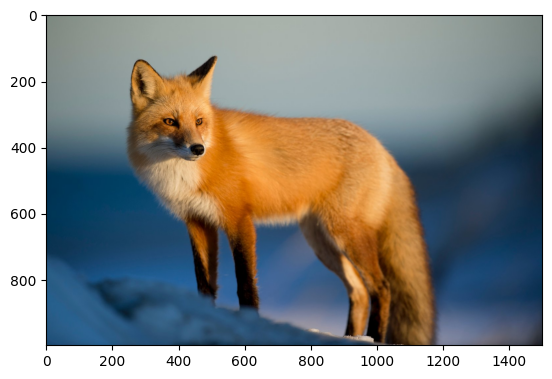

In [30]:
import cv2
import numpy as np
# AI 추론에 사용할 새로운 이미지 데이터 불러오기

 

image = cv2.cvtColor(cv2.imread('./data/red_fox.jpg'), code=cv2.COLOR_BGR2RGB)
print(f"image.shape:, {image.shape}")
# 입력된 새로운 이미지 데이터 크기를 AI 모델 입력 크기로 변환
input_image = cv2.resize(src=image, dsize=(224, 224))
print(f"resize_input_image.shape:, {input_image.shape}")
# AI 모델 입력 형태에 맞게 차원 확장 하기
input_image = np.expand_dims(input_image, 0)
print(f"expand_dims_input_image.shape:, {input_image.shape}")

 

import matplotlib.pyplot as plt
plt.imshow(image);

## 4. AI 추론

 

- input_image
- compiled_model
- output_layer



In [31]:
result_infer = compiled_model([input_image])[output_layer]
result_index = np.argmax(result_infer)
result_index

278

In [32]:
result_infer

array([[2.8543984e-05, 1.4690116e-05, 3.6370693e-05, ..., 2.1295109e-05,
        5.0335984e-05, 1.0422734e-05]], dtype=float32)

In [33]:
def get_element_at_position(result_infer, row, col):
    return result_infer[row, col]

# 예시: 0번째 행, 2번째 열의 값을 출력
print(get_element_at_position(result_infer, 0, 206))

8.654961e-06


In [34]:
def compare_numbers(a, b):
    if a > b:
        return f"{a} is greater than {b}"
    elif a < b:
        return f"{b} is greater than {a}"
    else:
        return f"{a} is equal to {b}"

# 숫자 비교
num1 = 3.8589977e-05
num2 = 0.77001953

print(compare_numbers(num1, num2))

0.77001953 is greater than 3.8589977e-05


* 참고
3.8589977e-05: e-05는 10의 -5제곱을 의미.
즉, 이 숫자는 3.8589977 × 10^-5로, 매우 작은 값. 소수점으로 표현하면 0.000038589977이 됩니다.
거의 0에 가까움

https://www.image-net.org/challenges/LSVRC/2012/browse-synsets.php

## 5. AI 추론 결과 출력

 

- 추론 결과 해석
- 추론 결과 출력

In [35]:
from pathlib import Path
imagenet_filename = Path('./data/imagenet_2012.txt')
# print(imagenet_filename)
imagenet_classes = imagenet_filename.read_text().splitlines()
# print(imagenet_classes)



In [36]:
# The model description states that for this model, class 0 is a background.
# Therefore, a background must be added at the beginning of imagenet_classes.

 

imagenet_classes = ["background"] + imagenet_classes
#print(imagenet_classes)
imagenet_classes[result_index]

'n02119022 red fox, Vulpes vulpes'

In [37]:
imagenet_classes[:5]

['background',
 'n01440764 tench, Tinca tinca',
 'n01443537 goldfish, Carassius auratus',
 'n01484850 great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'n01491361 tiger shark, Galeocerdo cuvieri']

In [39]:
imagenet_classes[278]

'n02119022 red fox, Vulpes vulpes'

## 배포: Gradio

In [1]:
import openvino as ov
import cv2
import numpy as np
import PIL
from pathlib import Path

In [2]:
# Load the model and prepare the input/output layers
core = ov.Core()
model = core.read_model(model='model/v3-small_224_1.0_float.xml')
compiled_model = core.compile_model(model=model, device_name="CPU")
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

In [3]:
# Load ImageNet classes
imagenet_filename = Path('data/imagenet_2012.txt')
imagenet_classes = imagenet_filename.read_text().splitlines()
imagenet_classes = ["background"] + imagenet_classes  # Include the background class

In [4]:
def preprocess(image):
    # Convert the PIL image to a NumPy array and resize to 224x224
    image = np.array(image)  # Convert PIL image to numpy array
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
    input_image = cv2.resize(src=image, dsize=(224, 224))
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
    return input_image

In [5]:
def predict_image(image):
    input_image = preprocess(image)  # Preprocess the image
    result_infer = compiled_model([input_image])[output_layer]  # Perform inference
    result_index = np.argmax(result_infer)  # Get the index of the highest score

    # Get the predicted class name
    predicted_class = imagenet_classes[result_index]
    return predicted_class  # Return just the predicted class name

In [6]:
import gradio as gr

 

# Set up the Gradio interface
gr.Interface(fn=predict_image,
             inputs=gr.Image(type="pil"),
             outputs=gr.Textbox(),  # Use Textbox to show the predicted class
             examples=["./data/coco.jpg"]).launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
